In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
import networkx as nx
from pyvis.network import Network
from scipy.stats import normaltest

## Load data

In [2]:
# Load significant miRNAs associated to treatments, divided into modules
path_miRNA = 'WGCNA_miRNA/output/'
file_list = ['significant_genes_black_data.GEMTAX.vs.all.txt',
    'significant_genes_blue_data.VSGT.vs.all.txt',
    'significant_genes_brown_data.VSGT.vs.all.txt',
    'significant_genes_red_data.VSGT.vs.all.txt',
    'significant_genes_yellow_data.VSGT.vs.all.txt']
 
miRNA_data = {}
for value in file_list:
    with open(path_miRNA + value, "r", encoding="utf-8") as file:
        miRNA_data['miRNA_'+value.split('_')[2]+'_'+value.split('.')[1].replace('GEMTAX', 'GT')] = [x.replace('\n', '').replace('.', '-') for x in file.readlines()]  # Salva nel dizionario
miRNA_data.keys()

dict_keys(['miRNA_black_GT', 'miRNA_blue_VSGT', 'miRNA_brown_VSGT', 'miRNA_red_VSGT', 'miRNA_yellow_VSGT'])

In [3]:
# Load significant mRNAs associated to treatments, divided into modules
path_RNA = 'WGCNA_mRNA/output/'
file_list1 = [
    'significant_genes_green_data.VS_GEMTAX.vs.all.txt',
    'significant_genes_green_data.CTR.vs.all.txt',
    'significant_genes_greenyellow_data.VPA.vs.all.txt',
    'significant_genes_magenta_data.VS_GEMTAX.vs.all.txt',
    'significant_genes_pink_data.VS_GEMTAX.vs.all.txt',
    'significant_genes_red_data.VS_GEMTAX.vs.all.txt',
    'significant_genes_tan_data.GEMTAX.vs.all.txt',
    'significant_genes_tan_data.VPA_SIM.vs.all.txt'
]
 
RNA_data = {}
for value in file_list1:
    with open(path_RNA + value, "r", encoding="utf-8") as file:
        RNA_data['RNA_'+value.split('_')[2]+'_'+value.split('.')[1].replace('VS_GEMTAX', 'VSGT').replace('VPA_SIM', 'VS').replace('GEMTAX', 'GT')] = [x.replace('\n', '').replace('.', '-') for x in file.readlines()]  # Salva nel dizionario
RNA_data.keys()

dict_keys(['RNA_green_VSGT', 'RNA_green_CTR', 'RNA_greenyellow_VPA', 'RNA_magenta_VSGT', 'RNA_pink_VSGT', 'RNA_red_VSGT', 'RNA_tan_GT', 'RNA_tan_VS'])

In [4]:
# Map gene_id to gene_name because WGCNA was done with gene_id but miRTarBase_MTI (for target analysis) uses gene_name
rna_data_path = 'WGCNA_mRNA/data/'
dict_id_name = pd.read_csv(rna_data_path+'salmon.merged.gene_counts.tsv', sep='\t', usecols=['gene_id', 'gene_name'])
id_to_name = dict(zip(dict_id_name['gene_id'], dict_id_name['gene_name']))
RNA_data = {
    key: [id_to_name.get(gene_id, gene_id) for gene_id in gene_list] for key, gene_list in RNA_data.items()
}

In [5]:
# load DB with miRNA targets
mirna_db = pd.read_csv('data/miRTarBase_MTI.csv')

# Keep only homo sapiens and drop duplicated rows
print(mirna_db.shape)
mirna_db_hsa = mirna_db[mirna_db['Species (miRNA)']=='hsa'].drop_duplicates()
print(mirna_db_hsa.shape)
mirna_db_hsa

(4671966, 9)
(1859322, 9)


,miRTarBase ID,miRNA,Species (miRNA),Target Gene,Target Gene (Entrez ID),Species (Target Gene),Experiments,Support Type,References (PMID)
9,MIRT003105,hsa-miR-122-5p,hsa,SLC7A1,6541.0,hsa,Luciferase reporter assay//Western blot,Functional MTI,17179747.0
10,MIRT003105,hsa-miR-122-5p,hsa,SLC7A1,6541.0,hsa,Luciferase reporter assay//Western blot,Non-Functional MTI,17179747.0
32,MIRT003112,hsa-miR-122-5p,hsa,ADAM17,6868.0,hsa,Luciferase reporter assay//qRT-PCR,Functional MTI,19296470.0
33,MIRT003112,hsa-miR-122-5p,hsa,ADAM17,6868.0,hsa,Luciferase reporter assay//qRT-PCR,Non-Functional MTI,19296470.0
34,MIRT003111,hsa-miR-122-5p,hsa,NUMBL,9253.0,hsa,Luciferase reporter assay//qRT-PCR,Non-Functional MTI,19296470.0
...,...,...,...,...,...,...,...,...,...
4671909,MIRT2696484,hsa-miR-875-3p,hsa,ZZEF1,23140.0,hsa,CLIP-seq,Functional MTI (Weak),NaN
4671912,MIRT2696485,hsa-miR-1322,hsa,ZZZ3,26009.0,hsa,CLIP-seq,Functional MTI (Weak),NaN
4671937,MIRT2696486,hsa-miR-4307,hsa,ZZZ3,26009.0,hsa,CLIP-seq,Functional MTI (Weak),NaN
4671947,MIRT2696487,hsa-miR-4698,hsa,ZZZ3,26009.0,hsa,CLIP-seq,Functional MTI (Weak),NaN


In [6]:
# Keep only targets with a Stong Support
mirna_db_hsa_strong = mirna_db_hsa[np.logical_not(mirna_db_hsa['Support Type'].str.contains('Weak'))]
print(mirna_db_hsa_strong.shape)
print('Number of miRNA: ', len(mirna_db_hsa.miRNA.unique().tolist()))
print('Number of miRNA strong: ', len(mirna_db_hsa_strong.miRNA.unique().tolist()))
mirna_db_hsa_strong_func = mirna_db_hsa_strong[mirna_db_hsa_strong['Support Type']=='Functional MTI']
print('Number of miRNA strong & functional: ', len(mirna_db_hsa_strong_func.miRNA.unique().tolist()))

(15211, 9)
Number of miRNA:  3056
Number of miRNA strong:  1024
Number of miRNA strong & functional:  1021


In [7]:
# save lists of targets for each miRNA in each miRNA module
target_dict = {}
for key in miRNA_data.keys():
    target_dict[key] = mirna_db_hsa_strong_func.loc[mirna_db_hsa_strong_func.miRNA.isin(miRNA_data[key]),['miRNA', 'Target Gene', 
                                                                                                'Experiments', 'Support Type']].drop_duplicates()
target_dict.keys()

dict_keys(['miRNA_black_GT', 'miRNA_blue_VSGT', 'miRNA_brown_VSGT', 'miRNA_red_VSGT', 'miRNA_yellow_VSGT'])

## Compare miRNA targets with RNA gene-modules

In [8]:
# Create a dict for each module and each miRNA in it with a list of their targets
mirna_genes_dict = {}
for module,db in target_dict.items():
    mirna_genes_dict[module] = db.groupby('miRNA')['Target Gene'].apply(list).to_dict()

# Create a dict for each module with a list of all the miRNAs target in that module
mirna_genes_dict_flat = {}
for module,db in target_dict.items():
    mirna_genes_dict_flat[module] = db['Target Gene'].drop_duplicates().tolist()
    
# checking that the genes here are deduplicated
[len(x) == len(set(x)) for x in mirna_genes_dict_flat.values()]

[True, True, True, True, True]

### Inspect genes modules searching for miRNAs targets divided into miRNAs modules

In [9]:
# Initialize matrix to see the intersections of genes in transcriptomic modules and miRNA's target modules
matrix_perc = pd.DataFrame(0.0, index=mirna_genes_dict_flat.keys(), columns=RNA_data.keys())
matrix_count = pd.DataFrame(0, index=mirna_genes_dict_flat.keys(), columns=RNA_data.keys())
matrix_overalp = pd.DataFrame([], index=mirna_genes_dict_flat.keys(), columns=RNA_data.keys())

# Fill matrix with counts of overlapping genes
for key1, target1 in mirna_genes_dict_flat.items(): # for cycle on miRNA targets
    for key2, genes2 in RNA_data.items(): # for cycle on mRNAs
        if len(target1) > 0 and len(genes2) > 0:
            overlap_perc = round((len(set(target1) & set(genes2)) / len(target1)) * 100, 2)
            overlap_count = len(set(target1) & set(genes2))
            overlap = list(set(target1) & set(genes2))
        else:
            overlap_perc = 0
            overlap_count = 0
            overlap = []
        matrix_perc.loc[key1, key2] = overlap_perc
        matrix_count.loc[key1, key2] = overlap_count
        matrix_overalp.loc[key1, key2] = overlap

# Display the results
matrix_count

,RNA_green_VSGT,RNA_green_CTR,RNA_greenyellow_VPA,RNA_magenta_VSGT,RNA_pink_VSGT,RNA_red_VSGT,RNA_tan_GT,RNA_tan_VS
miRNA_black_GT,0,0,0,0,0,0,0,0
miRNA_blue_VSGT,14,0,0,3,2,23,0,1
miRNA_brown_VSGT,19,0,0,1,5,15,0,0
miRNA_red_VSGT,9,1,0,5,2,6,0,0
miRNA_yellow_VSGT,34,0,0,4,4,22,0,1


In [10]:
# Create a df with the totals per row
dim_modules_RNA = []
[dim_modules_RNA.append(len(genes)) for genes in RNA_data.values()]
total_to_add = pd.DataFrame({'Total_RNA_module': dim_modules_RNA}).T
total_to_add.columns = matrix_count.columns
total_to_add

,RNA_green_VSGT,RNA_green_CTR,RNA_greenyellow_VPA,RNA_magenta_VSGT,RNA_pink_VSGT,RNA_red_VSGT,RNA_tan_GT,RNA_tan_VS
Total_RNA_module,762,10,7,71,198,554,2,9


In [11]:
# Add the total per row to the matrix_count and convert the final df in percentages
df_wilcoxon_test = pd.concat([matrix_count,total_to_add])
df_wilcoxon_test_perc = round(df_wilcoxon_test.div(df_wilcoxon_test.sum(axis=1), axis=0).fillna(0)*100,1)
df_wilcoxon_test_perc

,RNA_green_VSGT,RNA_green_CTR,RNA_greenyellow_VPA,RNA_magenta_VSGT,RNA_pink_VSGT,RNA_red_VSGT,RNA_tan_GT,RNA_tan_VS
miRNA_black_GT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
miRNA_blue_VSGT,32.6,0.0,0.0,7.0,4.7,53.5,0.0,2.3
miRNA_brown_VSGT,47.5,0.0,0.0,2.5,12.5,37.5,0.0,0.0
miRNA_red_VSGT,39.1,4.3,0.0,21.7,8.7,26.1,0.0,0.0
miRNA_yellow_VSGT,52.3,0.0,0.0,6.2,6.2,33.8,0.0,1.5
Total_RNA_module,47.2,0.6,0.4,4.4,12.3,34.3,0.1,0.6


#### Wilcoxon test

The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test (assumes normality).

In [12]:
df_wilcoxon_test_perc['pvals'] = 0.0
df_wilcoxon_test_perc['stats'] =  0.0
cols4test = ['RNA_green_VSGT', 'RNA_greenyellow_VPA', 'RNA_magenta_VSGT',
       'RNA_pink_VSGT', 'RNA_red_VSGT', 'RNA_tan_GT', 'RNA_tan_VS']

# Compute test and fill columns 
for index in df_wilcoxon_test_perc.index:
    # exclude those with all columns == 0 and set them to nan
    if (df_wilcoxon_test_perc.loc[index,].sum() != float(0)) & (index != 'Total_RNA_module'): 
        result = wilcoxon(df_wilcoxon_test_perc.loc[index, cols4test], df_wilcoxon_test_perc.loc['Total_RNA_module', cols4test])
        df_wilcoxon_test_perc.loc[index, 'pvals'] = round(result.pvalue,2)
        df_wilcoxon_test_perc.loc[index, 'stats'] = round(result.statistic,2)
    else:
        df_wilcoxon_test_perc.loc[index, 'pvals'] = np.nan
        df_wilcoxon_test_perc.loc[index, 'stats'] = np.nan
df_wilcoxon_test_perc

,RNA_green_VSGT,RNA_green_CTR,RNA_greenyellow_VPA,RNA_magenta_VSGT,RNA_pink_VSGT,RNA_red_VSGT,RNA_tan_GT,RNA_tan_VS,pvals,stats
miRNA_black_GT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
miRNA_blue_VSGT,32.6,0.0,0.0,7.0,4.7,53.5,0.0,2.3,1.00,14.0
miRNA_brown_VSGT,47.5,0.0,0.0,2.5,12.5,37.5,0.0,0.0,0.81,12.0
miRNA_red_VSGT,39.1,4.3,0.0,21.7,8.7,26.1,0.0,0.0,0.30,7.0
miRNA_yellow_VSGT,52.3,0.0,0.0,6.2,6.2,33.8,0.0,1.5,0.94,13.0
Total_RNA_module,47.2,0.6,0.4,4.4,12.3,34.3,0.1,0.6,NaN,NaN


### Plot info about modules intersections

In [13]:
matrix_color = pd.DataFrame('', index=matrix_count.index, columns=matrix_count.columns)
color_list = ['darkgreen', 'black', 'darkmagenta', 'hotpink', 'red', 'darkgoldenrod']

# assign a color to each mRNA module (by column)
color_col = 0
for col in matrix_count.columns:
    if matrix_count[col].sum() != 0:
        matrix_color[col] = color_list[color_col]
        color_col += 1
matrix_color

,RNA_green_VSGT,RNA_green_CTR,RNA_greenyellow_VPA,RNA_magenta_VSGT,RNA_pink_VSGT,RNA_red_VSGT,RNA_tan_GT,RNA_tan_VS
miRNA_black_GT,darkgreen,black,,darkmagenta,hotpink,red,,darkgoldenrod
miRNA_blue_VSGT,darkgreen,black,,darkmagenta,hotpink,red,,darkgoldenrod
miRNA_brown_VSGT,darkgreen,black,,darkmagenta,hotpink,red,,darkgoldenrod
miRNA_red_VSGT,darkgreen,black,,darkmagenta,hotpink,red,,darkgoldenrod
miRNA_yellow_VSGT,darkgreen,black,,darkmagenta,hotpink,red,,darkgoldenrod


In [14]:
G = nx.MultiGraph()

# List of nodes' names
nodes = list(miRNA_data.keys())+list(RNA_data.keys())
# List of nodes' dimentions
dim = [len(x) for x in miRNA_data.values()]+[len(x) for x in RNA_data.values()]

# Add nodes
for i, node in enumerate(nodes):
    G.add_node(node, size=dim[i], border = 'grey',
               color='gold' if 'miRNA' in node else 'limegreen')
# Add edges
for index in matrix_count.index:
    for col in matrix_count.columns:
        if matrix_count.loc[index, col] !=0:
            for i in range(matrix_count.loc[index, col]):
                G.add_edge(index, col, color = matrix_color.loc[index, col])

# Create a Network with pyvis to visualise the network in a plot
net = Network(directed=True)
# Import G from networkX
net.from_nx(G)

for n in net.nodes:
    n['borderWidth'] = 2
    n['color'] = {'border': 'grey', 'background': n['color']}

net.set_edge_smooth('dynamic')
net.show_buttons()

# Save the plot in an html file
net.save_graph("network_plot/graphviz_target_modules.html")

## Correlation Analysis of counts between miRNAs and their targets divided in mRNA modules (where present)

In [15]:
intersections_dict = {}

# Fill matrix with counts of overlapping genes
for module_mirna in mirna_genes_dict.keys(): 
    for module_gene, genes in RNA_data.items():
        intersections_dict[module_mirna+'_'+module_gene] = {}
        for mirna, targets in mirna_genes_dict[module_mirna].items():
            intersection = list(set(genes) & set(targets))
            if len(intersection) > 0:
                intersections_dict[module_mirna+'_'+module_gene][mirna] = intersection

print(intersections_dict.keys())

dict_keys(['miRNA_black_GT_RNA_green_VSGT', 'miRNA_black_GT_RNA_green_CTR', 'miRNA_black_GT_RNA_greenyellow_VPA', 'miRNA_black_GT_RNA_magenta_VSGT', 'miRNA_black_GT_RNA_pink_VSGT', 'miRNA_black_GT_RNA_red_VSGT', 'miRNA_black_GT_RNA_tan_GT', 'miRNA_black_GT_RNA_tan_VS', 'miRNA_blue_VSGT_RNA_green_VSGT', 'miRNA_blue_VSGT_RNA_green_CTR', 'miRNA_blue_VSGT_RNA_greenyellow_VPA', 'miRNA_blue_VSGT_RNA_magenta_VSGT', 'miRNA_blue_VSGT_RNA_pink_VSGT', 'miRNA_blue_VSGT_RNA_red_VSGT', 'miRNA_blue_VSGT_RNA_tan_GT', 'miRNA_blue_VSGT_RNA_tan_VS', 'miRNA_brown_VSGT_RNA_green_VSGT', 'miRNA_brown_VSGT_RNA_green_CTR', 'miRNA_brown_VSGT_RNA_greenyellow_VPA', 'miRNA_brown_VSGT_RNA_magenta_VSGT', 'miRNA_brown_VSGT_RNA_pink_VSGT', 'miRNA_brown_VSGT_RNA_red_VSGT', 'miRNA_brown_VSGT_RNA_tan_GT', 'miRNA_brown_VSGT_RNA_tan_VS', 'miRNA_red_VSGT_RNA_green_VSGT', 'miRNA_red_VSGT_RNA_green_CTR', 'miRNA_red_VSGT_RNA_greenyellow_VPA', 'miRNA_red_VSGT_RNA_magenta_VSGT', 'miRNA_red_VSGT_RNA_pink_VSGT', 'miRNA_red_VSGT_RN

In [16]:
# select miRNAs and mRNAs foe which to compute the correlation
dict4corr = {}
for modules, sub_dict in intersections_dict.items():
    mirna = list(sub_dict.keys())
    targets = list(set(gene for genes in sub_dict.values() for gene in genes))
    dict4corr[modules] = {"mirna": mirna, "targets": targets}

### Load counts data

In [17]:
mirna_data_path = 'WGCNA_miRNA/data/'
rna_data_path = 'WGCNA_mRNA/data/'

mirna_counts = pd.read_csv(mirna_data_path+'mature_counts.csv').set_index('Unnamed: 0').T.sort_index(axis=1)
rna_counts = pd.read_csv(rna_data_path+'salmon.merged.gene_counts.tsv', sep='\t').drop(columns='gene_id')
rna_counts.columns = [x.replace('VPA_SIM', 'VPASIM').replace('VS_GEMTAX', 'VSGT') for x in rna_counts.columns]

In [18]:
# Nomalization of mirna and rna counts with log10
mirna_counts_norm = np.log10(mirna_counts + 1e-5)
rna_counts_norm = np.log10(rna_counts.drop(columns=['gene_name']) + 1e-5)
rna_counts_norm['gene_name'] = rna_counts['gene_name']

In [19]:
# Check if there is a normal distribution in the normalized data
print('miRNA p<0.05 normality: ', normaltest(mirna_counts_norm, axis=0).pvalue < 0.05)
print('mRNA p<0.05 normality: ', normaltest(rna_counts_norm.drop(columns=['gene_name']), axis=0).pvalue < 0.05)

miRNA p<0.05 normality:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
mRNA p<0.05 normality:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]


### Compute correlation between miRNAs and their targets

In [20]:
# modules with at leas 5 targets in the intersections
interesting_modules = ['miRNA_blue_VSGT_RNA_green_VSGT', 'miRNA_blue_VSGT_RNA_red_VSGT', 
                    'miRNA_brown_VSGT_RNA_green_VSGT', 'miRNA_brown_VSGT_RNA_pink_VSGT', 'miRNA_brown_VSGT_RNA_red_VSGT', 
                    'miRNA_red_VSGT_RNA_green_VSGT', 'miRNA_red_VSGT_RNA_magenta_VSGT', 'miRNA_red_VSGT_RNA_red_VSGT',
                    'miRNA_yellow_VSGT_RNA_green_VSGT', 'miRNA_yellow_VSGT_RNA_red_VSGT']

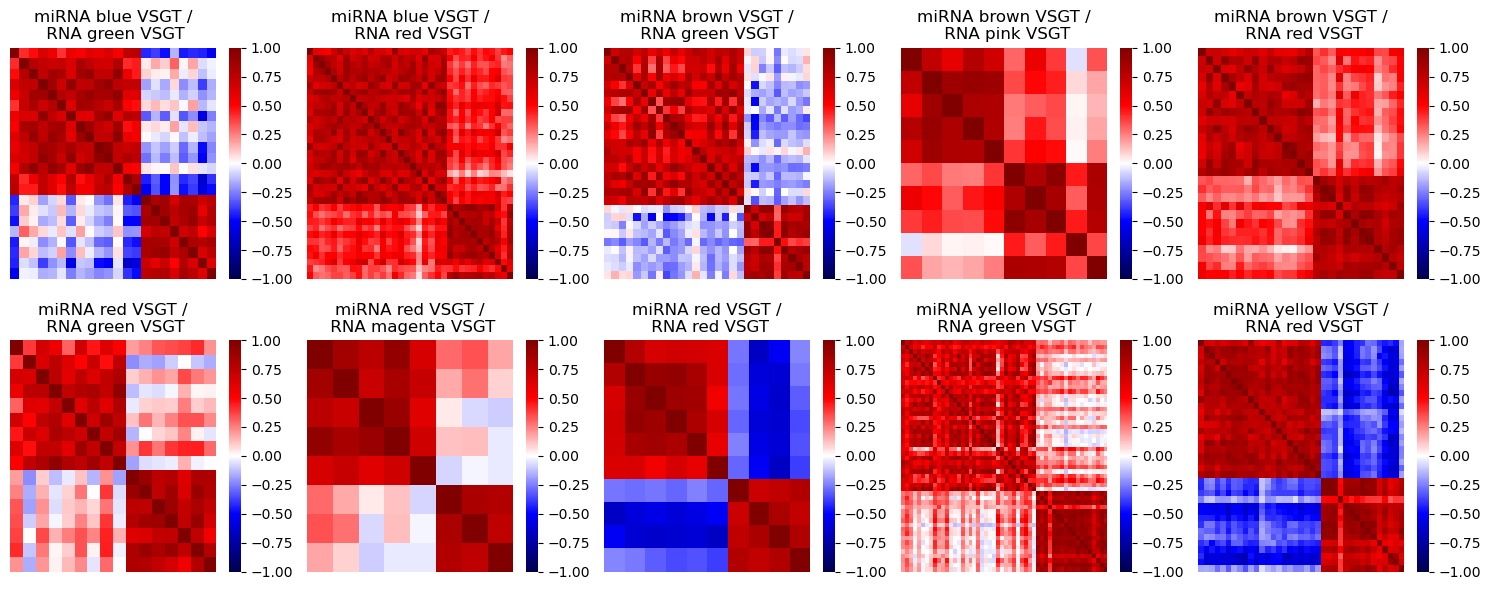

In [21]:
# Compute and plot the correlation matrixes
n_cols = 5
n_rows = 2
n_plots = len(interesting_modules)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

for index, name in enumerate(interesting_modules):

    row = index // n_cols
    col = index % n_cols
    
    # Create df to compute correlation
    df4corr = pd.concat([rna_counts_norm[rna_counts_norm.gene_name.isin(dict4corr[interesting_modules[index]]['targets'])].set_index('gene_name'), 
                        mirna_counts_norm.loc[dict4corr[interesting_modules[index]]['mirna']]]).T

    # Create heatmap
    sns.heatmap(df4corr.corr(method='spearman'), vmin=-1, vmax=1, cmap='seismic', ax=axs[row, col])
    axs[row, col].set_title(name.replace('_RNA', ' /\n RNA').replace('_', ' '))
    axs[row, col].set_yticks([])
    axs[row, col].set_xticks([])

for i in range(n_plots, n_rows*n_cols):
    row = i // n_cols
    col = i % n_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

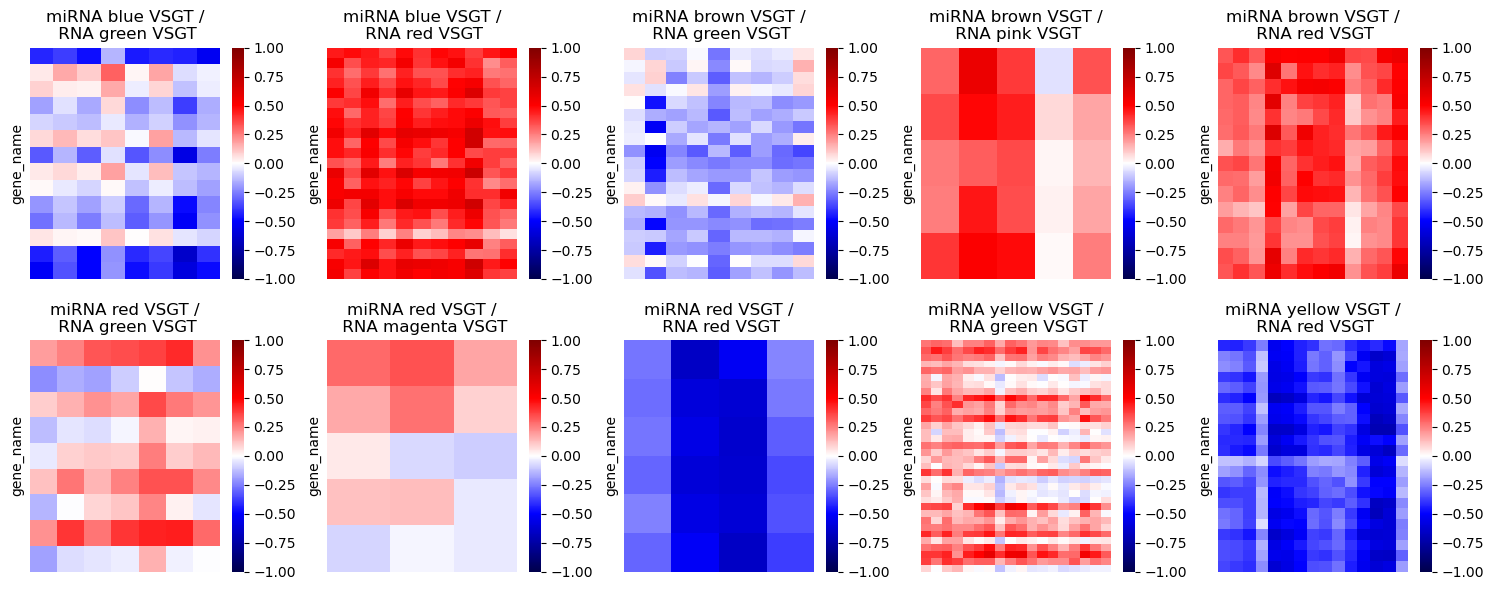

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

n_cols = 5
n_rows = 2
n_plots = len(interesting_modules)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

for index, name in enumerate(interesting_modules):
    row = index // n_cols
    col = index % n_cols

    targets = dict4corr[interesting_modules[index]]['targets']
    mirnas = dict4corr[interesting_modules[index]]['mirna']

    df_targets = rna_counts_norm[rna_counts_norm.gene_name.isin(targets)].set_index('gene_name').T
    df_mirnas = mirna_counts_norm.loc[mirnas].T

    # Align sample indices
    df_targets, df_mirnas = df_targets.align(df_mirnas, join='inner', axis=0)

    # Initialize correlation matrix: targets × miRNAs
    corr_matrix = pd.DataFrame(index=df_targets.columns, columns=df_mirnas.columns, dtype=float)

    # Compute pairwise Spearman correlations
    for t in df_targets.columns:
        for m in df_mirnas.columns:
            corr, _ = spearmanr(df_targets[t], df_mirnas[m])
            corr_matrix.loc[t, m] = corr

    # Plot heatmap
    sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='seismic', ax=axs[row, col])
    axs[row, col].set_title(name.replace('_RNA', ' /\n RNA').replace('_', ' '))
    axs[row, col].tick_params(axis='x', labelrotation=90, labelsize=6)
    axs[row, col].tick_params(axis='y', labelsize=6)
    axs[row, col].set_yticks([])
    axs[row, col].set_xticks([])

# Hide unused subplots
for i in range(n_plots, n_rows*n_cols):
    row = i // n_cols
    col = i % n_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()
